In [1]:
import json
import pprint
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from IPython.display import display
from matplotlib.lines import Line2D
from sqlalchemy import create_engine

engine = create_engine("sqlite:///project2.sqlite")

# DATA EXTRACTION

### UK data extraction via .csv

In [2]:
df = pd.read_csv("uk_data.csv")
df.columns = ["Date","Number"]
df.dropna(inplace=True)

df.drop([2,3,5], inplace=True)

df.reset_index(drop=True,inplace=True)
df.set_index("Date")

# Data tansformation from .csv file. Taking data in dictionaries and adding a new column with only year, in order to be
# able to 'groupby' in coming steps.
df['Number'] = [int(num) for num in df['Number']]
df['year'] = [dt[-2:] for dt in df.Date]

# Groupping and summing by the newly added column to get total number of crimes per year.
gpb = df.groupby('year').sum()

# Removing the last year to match the year in other countries crime datasets.
gpb = gpb[:-1]
display(gpb)

,Number
year,
15,3402114
16,4814467
17,5457761
18,5835033
19,6090632


In [ ]:
'''
ddd = df.Date[-2:].dt.year
v = [dt[-2:] for dt in df.Date]
print(v)
'''

### Canada data scrapped using 'Beautiful Soup'

In [3]:
cad_url = "https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701"
page = requests.get(cad_url)
cad_soup = BeautifulSoup(page.text, 'html.parser')

**US Data Scrape**

In [4]:
url = "http://www.disastercenter.com/crime/uscrime.htm"
tables = pd.read_html(url)
df = tables[1]
df_number = df[72:77]
df_number.reset_index(inplace = True)

df_rate = df[149:154]
df_rate.reset_index(inplace = True)

In [5]:
df_rate = df_rate[[0, 2]]
df_rate.columns = ["Date", "Rate"]

In [6]:
df_number = df_number[[0, 2]]
df_number.columns = ["Date", "Number"]

In [7]:
us_df = df_number.merge(df_rate, how = "outer")
us_df

,Date,Number,Rate
0,2015,9258298,2885.1
1,2016,9214136,2849.1
2,2017,8966863,2757.8
3,2018,8471483,2593.2
4,2019,8171087,2489.3


# Transformations 1:

In [8]:
cad_srp = cad_soup.find("script",id='csvContent')
table = {}
a = 0
for aa in cad_srp:
    for b in aa.split('\n'):
        if len(b[1:-1].split('","')) == 6:
            table[b[1:-1].split('","')[0]] = b[1:-1].split('","')[1:]
            a+=1
        if a == 2:
            break

table = pd.DataFrame(table)
table.columns = ['Date','Number']
display(table)

,Date,Number
0,2015,"2,118,681"
1,2016,"2,161,927"
2,2017,"2,213,293"
3,2018,"2,280,328"
4,2019,"2,438,518"


In [9]:
aus_url = "https://www.abs.gov.au/statistics/people/crime-and-justice/recorded-crime-offenders/2019-20"
page = requests.get(aus_url)
aus_soup = BeautifulSoup(page.text, 'html.parser')

# Transformation 2:

In [10]:
aus_scrp = aus_soup.find_all("table")
aa = aus_scrp[0].find_all('th')
bb = aus_scrp[0].find_all('td')
data = {'Date':[],'Numbers':[]}
for year, number in zip(aa[-5:],bb[-5:]):
    data['Date'].append(year.text)
    data['Numbers'].append(int(number.text.replace(',','')))    

data = pd.DataFrame(data)
display(data)

,Date,Numbers
0,2015-16,64014
1,2016-17,61198
2,2017-18,61237
3,2018-19,53583
4,2019-20,40975


# Data transformation 3, and combined crime record:

In [11]:
data.columns = ['Date','Australia']
data['Canada']=[int(num.replace(',','')) for num in table['Number']]
data['UK'] = list(gpb['Number'])
data['US'] = [int(num) for num in list(us_df['Number'])]
display(data)

,Date,Australia,Canada,UK,US
0,2015-16,64014,2118681,3402114,9258298
1,2016-17,61198,2161927,4814467,9214136
2,2017-18,61237,2213293,5457761,8966863
3,2018-19,53583,2280328,5835033,8471483
4,2019-20,40975,2438518,6090632,8171087


# DATA LOADING

In [12]:
data.to_sql("combined_data", engine, if_exists = 'replace')

In [13]:
pd.read_sql("SELECT * FROM combined_data", engine)

,index,Date,Australia,Canada,UK,US
0,0,2015-16,64014,2118681,3402114,9258298
1,1,2016-17,61198,2161927,4814467,9214136
2,2,2017-18,61237,2213293,5457761,8966863
3,3,2018-19,53583,2280328,5835033,8471483
4,4,2019-20,40975,2438518,6090632,8171087


# VISUALIZATIONS

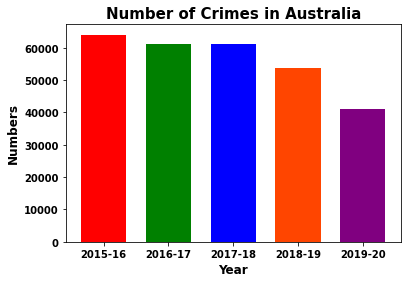

In [14]:
# Australia
plt.figure()
plt.bar(data['Date'], data['Australia'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in Australia', fontsize = 15, fontweight = 'bold')
plt.show()

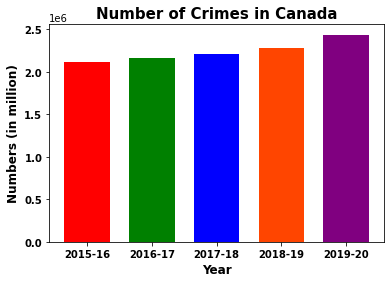

In [15]:
# Canada
plt.figure()
plt.bar(data['Date'], data['Canada'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in Canada', fontsize = 15, fontweight = 'bold')
plt.show()

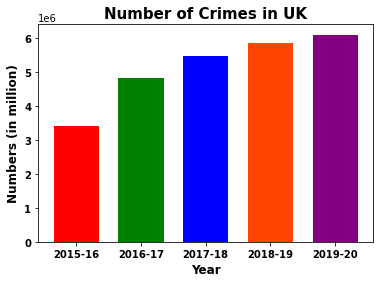

In [16]:
# UK
plt.figure()
plt.bar(data['Date'], data['UK'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in UK', fontsize = 15, fontweight = 'bold')
plt.show()

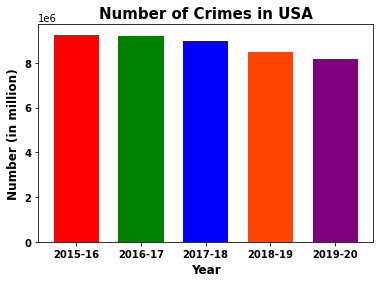

In [17]:
# USA
plt.figure()
plt.bar(data['Date'],data['US'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Number (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in USA', fontsize = 15, fontweight = 'bold')
plt.show()

(array([       0.,  2000000.,  4000000.,  6000000.,  8000000., 10000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

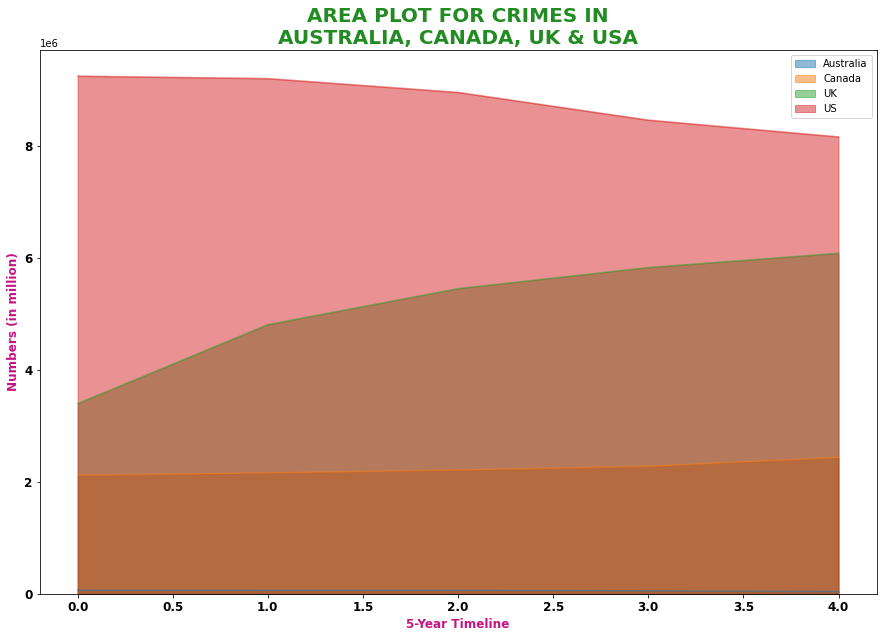

In [18]:
#ax = data.plot.area(stacked = False, title = 'Area plot for Crimes in Australia, Canada, UK and USA\n', figsize = (20, 10), ylabel = 'Numbers (in 100,000)', xlabel = '5-Year Timeline')
ax = data.plot.area(stacked = False, figsize = (15, 10))
plt.legend(loc = 'upper right')
plt.title('AREA PLOT FOR CRIMES IN\nAUSTRALIA, CANADA, UK & USA', size = 20, c = 'forestgreen', fontweight = 'bold')
plt.xlabel('5-Year Timeline', fontsize = 12, c = 'mediumvioletred', fontweight = 'bold')
plt.ylabel('Numbers (in million)', fontsize = 12, c = 'mediumvioletred', fontweight = 'bold')
plt.xticks(fontsize = 12, rotation = 'horizontal', fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')